In [95]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.optimize as sopt

plt.rcParams["figure.figsize"] = (6,3)

# Data science & Python & Machine Learning

### Машинное обучение: deep learning

### Представление текстов

- Долгое время единственной альтернативой для представления текстов был one-hot encoding
- Это до сих пор один из лучших вариантов
- Все изменилось примерно в 2013

### Векторная модель

- Distributed representation: "смысл" хранится не в отдельных признаках, а во всех сразу
- Смысл приобретает не каждый признак, а их совокупность
- Каждое слово можно представить как, например, 100-мерный вектор
- В 2013 это наконец заработало

In [96]:
from gensim.models import FastText
sentences = [
    ["woman", "likes", "man"],
    ["man", "likes", "woman"],
    ["red", "is", "not", "green"],
    ["green", "is", "not", "red"],
]

model = FastText(sentences, min_count=1, size=3)

def word_vector(word):
    return model.wv[word]

import scipy.spatial.distance as ssd
def cosine(lhs, rhs):
    return 1.0 - ssd.cosine(lhs, rhs)

In [97]:
word_vector('man'), word_vector('woman')

(array([-0.04007938, -0.01275139, -0.05766938], dtype=float32),
 array([-0.04248664,  0.01283036,  0.04082424], dtype=float32))

In [98]:
cosine(word_vector('man'), word_vector('woman'))

-0.18936727941036224

In [99]:
cosine(word_vector('red'), word_vector('green'))

0.4320699870586395

In [100]:
cosine(word_vector('green'), word_vector('man'))

0.8103324770927429

### Предложения

- Если у нас есть хорошее векторное представление слов, то есть и представление предложений
- Для этого нужно всего лишь складывать векторы слов 
- Но иногда слова лучше взвешивать, например TF-IDF

In [101]:
cosine(word_vector('green') + word_vector('red'), word_vector('man') + word_vector('woman'))

0.9833478927612305

### Построение векторных представлений

- В 2013 году появился Word2vec, который эффективно позволяет строить такие векторы
- Постепенно алгоритмы улучшали и текущим state of the art можно назвать fastText
- Детали алгоритмов не так важны на практике

### fastText, обученный на Simple English Wikipedia

In [108]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('wiki.simple.vec', binary=False)

In [115]:
word_vectors.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)

[('queen', 0.512911856174469),
 ('kingship', 0.48364710807800293),
 ('kingz', 0.48005008697509766),
 ('kings', 0.4712163209915161),
 ('adulyadej', 0.46895405650138855)]

### Использование векторных представлений

- Каждый признак слова отдельно почти ничего не значит (distributed representation)
- Лучше всего над такими признаками будет работать kNN или нейронные сети

### Нейронные сети

- Все началось с попытки повторить устройство мозга
- К нейронным сетям был всплеск интереса в 60-х и была "зима" в 80-е и 90-е
- Сейчас все об этом только и говорят

### Нейрон

In [250]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def neuron(x, w):
    return sigmoid(sum(x_i*w_i for (x_i, w_i) in zip(x, w)))

neuron([1.0, 2.0], [3.0, 4.0])

0.999983298578152

### Сеть нейронов

In [251]:
w_1 = np.random.randn(2); w_2 = np.random.randn(2); w_3 = np.random.randn(2)

x = [1.0, 2.0]
neuron(
    [neuron(x, w_1), neuron(x, w_2)],
    w_3
)

0.5623395961708421

### Deep learning

- Область, которая изучает алгоритмы, строящие иерархическое представление данных
- Так просто получилось, что лучше всего для этого подходят нейронные сети

### Deep learning работает

- С 2011 в соревновании ImageNet начали побеждать нейросетевые алгоритмы
- Потому что появилось много данных
- И потому что появились мощные компьютеры (в частности GPU)
- Но самое главное - появились биологически не обоснованные, но работающие алгоритмы

### Структура сети

- Линейные преобразования: аналогично линейным моделям
- Нелинейные преобразования (функции активации)
- Наша цель в поиске параметров всех нейронов: `w_1, w_2, w_3, ...`

### Слои

- Нейроны одного уровня можно объединять в слои
- Сеть состоит из нескольких слоёв, применяемых по очереди

In [252]:
def layer(x, w):
    return [neuron(x, w[0]), neuron(x, w[1])]
def network(x):
    w = np.random.randn(2, 2, 2)
    return layer(
        layer(x, w[0]), 
        w[1]
    )
network([1.0, 2.0])

[0.711398207395823, 0.7525616546696261]

### Оптимизация

- Мы уже использовали оптимизацию для поиска параметров линейной модели
- Теперь мы хотим оптимизировать параметры нейронов
- Лучше всего оптимизировать функцию, у которой есть градиент

### Градиент

- Вектор производных по каждому из параметров
- Направление наискорейшего роста функции
- В нашем контексте направление, в котором надо изменить параметры, чтобы ошибка стала меньше

### Цепное правило

- Рассмотрим $f(x) = x^2$, $g(x) = \sin x$
- $\frac{d}{dx} g(f(x)) = \frac{d}{dx} g(x) \times \frac{d}{dx} f(x) = \cos x^2 \times 2 x$
- Так можно дифференцировать совершенно любую функцию, даже нейронную сеть 

### Градиентный спуск

- Начинаем с некоторой $w_0$ и двигаемся с учетом градиента
- В контексте нейронных сетей цепное правило и градиентный спуск принято называть backpropagation
- В идеале градиент нужно считать по всей выборке, но считают по случайным batch (100-1000 примеров) 
- Для нейронных сетей изобрели множество улучшений градиентного спуска: Adam, RMSProp, их и следует применять на практике

### Нейронные сети?

- Не нейронные и не сети
- Сложные дифференцируемые функции с обучаемыми параметрами
- Вся победа лишь в том, что мы осмелились и смогли обучать разные сложные функции
- Интересно изучать свойства с помощью http://playground.tensorflow.org

### На практике

In [237]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

### Затухание градиента

- Сигмоид, который мы использовали с самого начала - биологически обоснованная функция, но ее производные иногда становятся слишком маленькими
- Нет производных - нет обучения
- Сейчас все используют функцию, которая называется Rectified Linear Unit (ReLU):

In [238]:
def relu(x):
    return max(0, x)

relu(10.0), relu(-10.0)

(10.0, 0)

### Dropout, Batch normalization

- Dropout - устраняет переобучение, выбрасывая случайные нейроны
- Batch normalization - способ нормализации промежуточных представлений 
- Изучайте примеры, чтобы понять где они нужны

### Проблема инвариантности

- Пиксельное представление очень сильно меняется даже когда на изображении то же самое
- Нам нужно инвариантное или хотя бы эквивариантное представление
- Аналогично для звука и временных данных

### Свертка

- Операция изменяющая каждый пиксель, используя соседние
- Важный блок для обработки изображений
- Описывается матрицей:

In [147]:
w = np.array(
    [[-1, 0, 1],
     [-1, 0, 1],
     [-1, 0, 1]]
)

Посмотрим изображение:

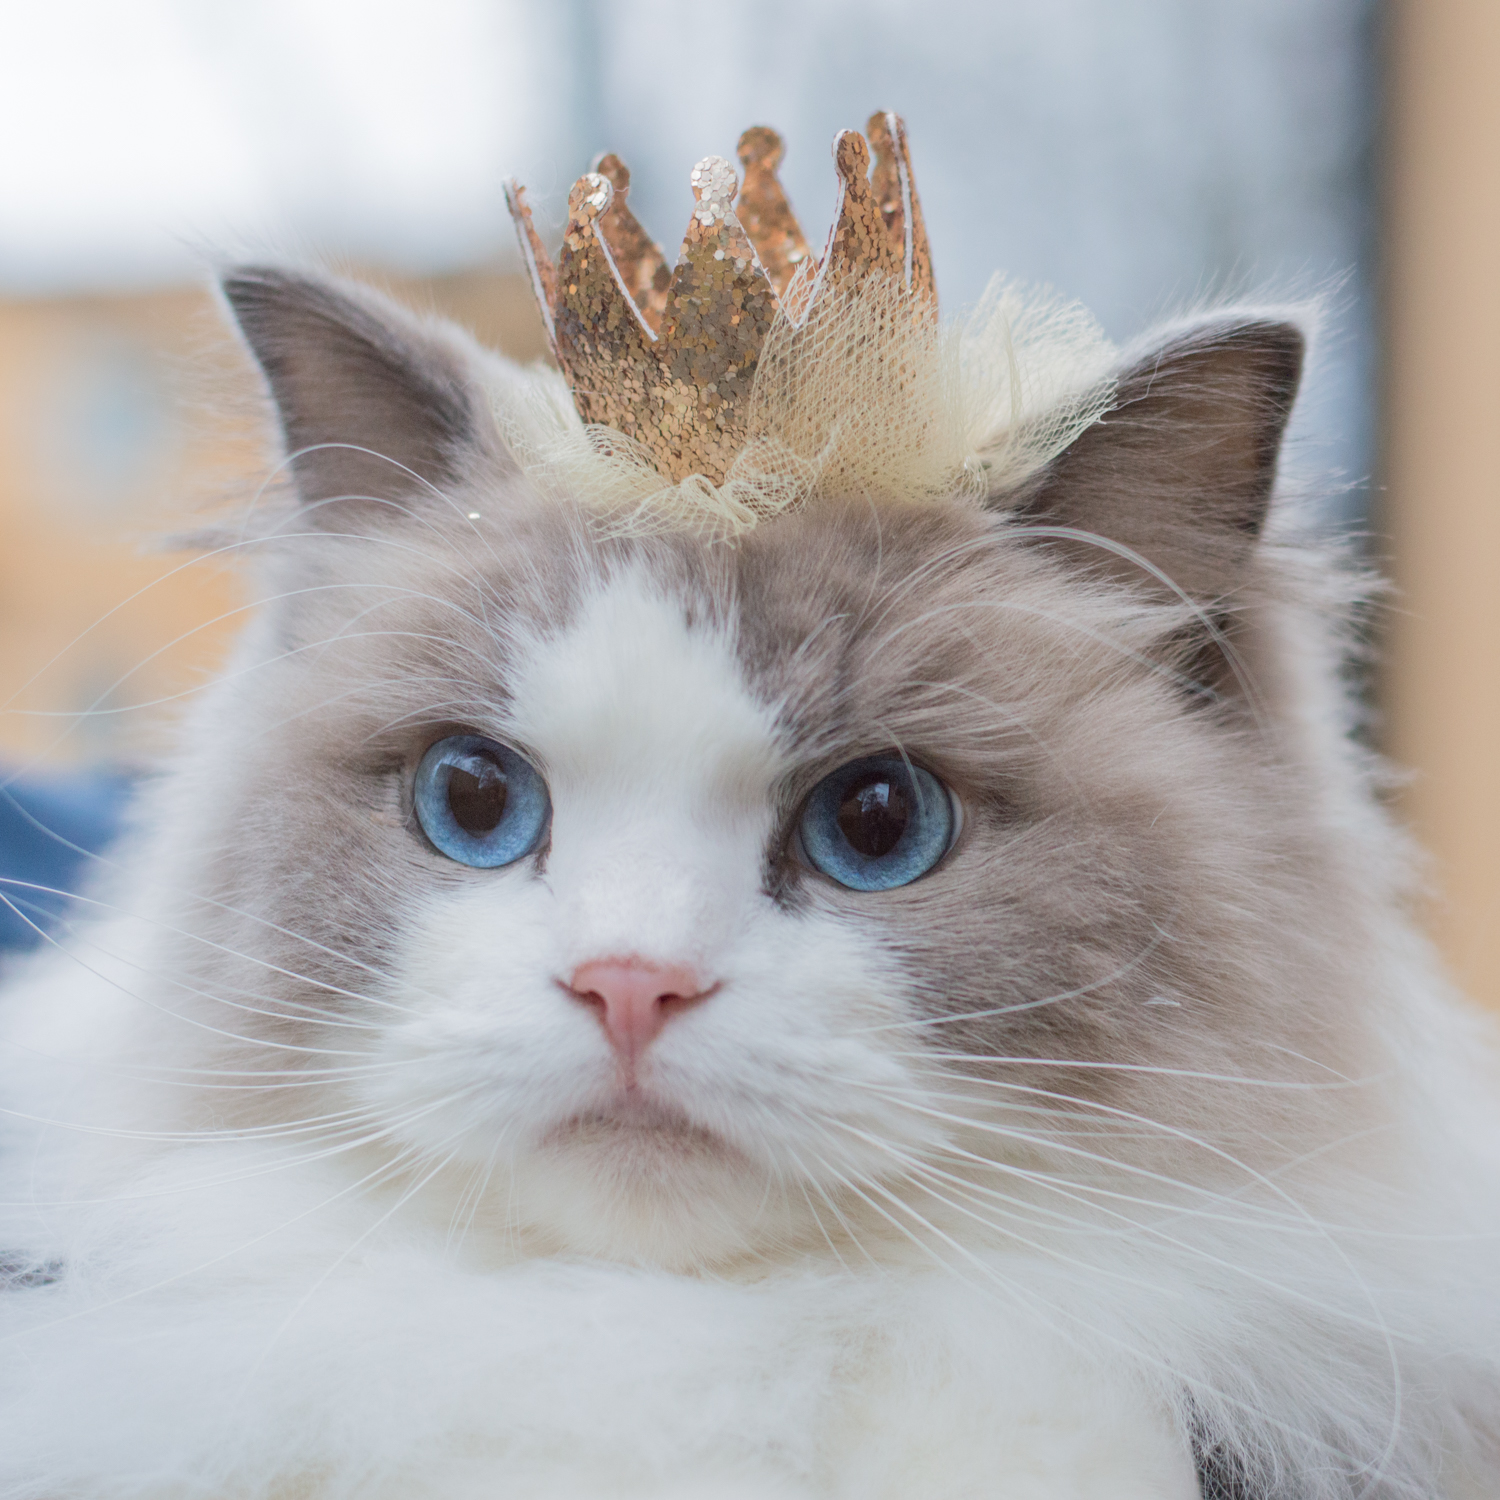

In [203]:
from IPython.display import Image
img = Image('aurora.jpg', width=300); img

Загрузим изображение в виде матрицы:

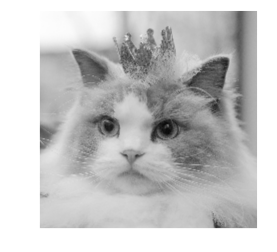

In [204]:
from scipy.ndimage.io import imread
cat = imread('aurora.jpg'); cat = cat.mean(axis=2)
plt.imshow(cat, cmap=plt.cm.gray);
plt.axis('off');

Применим исходный фильтр:

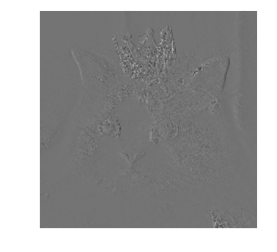

In [191]:
from scipy.ndimage.filters import convolve
plt.imshow(convolve(cat, w), cmap=plt.cm.gray);
plt.axis('off');

Сделаем свертку с другой матрицей (box blur):

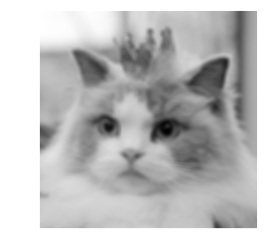

In [205]:
from scipy.ndimage.filters import convolve
blur = np.ones((31, 31), dtype=np.float32)
plt.imshow(convolve(cat, blur), cmap=plt.cm.gray);
plt.axis('off');

### Сверточная нейронная сеть (CNN)

- Нейронная сеть, в которой есть слои, делающие свертку
- Коэффициенты свертки обучаются ровно так же, как остальные параметры
- Мы применяем много разных сверток и постепенно снижаем размер изображения
- Оптимизационный алгоритм учит сеть преобразовывать изображение, чтобы решать задачу стало легче

### Предобученные сверточные нейронные сети

- Обучать нейронную сеть для изображений чрезвычайно дорого
- Мало у кого есть столько данных, столько времени и столько вычислительных ресурсов
- Ровно как и fastText, CNN, обученная для одной задачи, полезна для другой

Загрузим модель ResNet50 с помощью keras:

In [241]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

model = ResNet50(weights='imagenet')

Модель состоит из множества слоёв:

In [244]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_10[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_442 (Activation)     (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

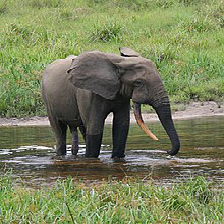

In [248]:
from IPython.display import Image
img = image.load_img('elephant.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
img

In [249]:
predictions = model.predict(x)
pd.DataFrame(decode_predictions(predictions, top=5)[0])

,0,1,2
0,n02504458,African_elephant,0.880432
1,n01871265,tusker,0.088120
2,n02504013,Indian_elephant,0.031420
3,n01704323,triceratops,0.000006
4,n02408429,water_buffalo,0.000004


### Домашнее задание

- Обучить нейронную сеть на рукописных цифрах
- Изучить, как она реагирует на разные цифры и когда ошибается

### Что дальше?

- Если вам хочется разобраться глубже - Coursera и книги
- Если хочется практики, но её нет - то вам очень поможет Kaggle
- Попытайтесь применять полученные навыки, вы на самом деле уже много умеете
- Список курсов и книг, которые я считаю интересными, будет в письме